## MNIST - simple linear model
This notebook will help with two things:
1. It gives you a code template without all of the explanation. Once you understand the basic principles, that may be helpful in terms of having less to wade through.
2. It substitutes the convolutional model for a linear model. There are lots of instances where a linear model is all that you need.

So, to understand this notebook, please look at the mnist_demo.ipynb notebook which has almost all of the same code but with lots of explanation.

In [1]:
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from mnist_dataset import MnistDataset

In [2]:
GPU_AVAILABLE = torch.cuda.is_available()
GPU_AVAILABLE

True

## Load up the datasets

In [3]:
data_root = Path('../data')

In [4]:
test_ds = MnistDataset(data_root, 'test')
train_ds = MnistDataset(data_root, 'train')

## The model

This is the main piece of code that's different - it's a linear model rather than a convolutional model.

In [18]:
class LinearMnistModel(nn.Module):
    def __init__(self):
        super(LinearMnistModel, self).__init__()

        self.linear_layer1 = nn.Linear(28 * 28, 10)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.linear_layer1(x)
        return self.softmax(x)

In [19]:
model = LinearMnistModel()
model = model.cuda() if GPU_AVAILABLE else model
model

LinearMnistModel(
  (linear_layer1): Linear(in_features=784, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

In [20]:
batch_size = 100
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [21]:
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train and test

In [9]:
def train_batch(model, batch, optimizer, loss_function):
    """
    Trains the model on a single batch of data.

    Args:
        model (nn.Module): The PyTorch model to train.
        batch (dict): A dictionary containing the input data and labels for a single batch.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        loss_function (nn.Module): The loss function to use for training.

    Returns:
        float: The loss value for the batch.
    """
    # Get the input data and labels from the batch
    x, y = batch['x'], batch['Y']
    # Move the data to the correct device, that is, onto the GPU if we have one available.
    if GPU_AVAILABLE:
        x, y = x.cuda(), y.cuda()

    # This next line is boilerplate PyTorch. It tells PyTorch to reset all gradients.
    # You'll use this line as-is most of the time.
    optimizer.zero_grad()

    # Compute the output of the model using the input data.
    output = model(x)
    # Calculate the loss using the output of the model and the correct labels.
    loss = loss_function(output, y)

    # This next lines are also boilerplate PyTorch.You'll use them as-is most of the time.
    # loss.backward() tells PyTorch to compute gradients based on the loss function.
    loss.backward()
    # optimizer.step() tells PyTorch to update the model parameters based on those gradients.
    optimizer.step()

    return loss.item()


In [10]:
def train_epoch(model, train_dl, optimizer, loss_function):
    """
    Trains the model for a single epoch.

    Args:
        model (nn.Module): The PyTorch model to train.
        train_dl (DataLoader): The DataLoader containing the training data.
        optimizer (torch.optim.Optimizer): The optimizer to use for training.
        loss_function (nn.Module): The loss function to use for training.

    Returns:
        float: The average loss value for the epoch.
    """
    total_loss = 0
    num_batches = len(train_dl)
    running_loss = 0
    print_every = 10
    model.train() # set model to training mode

    for i, batch in enumerate(train_dl):

        # This next line is all that we need to run through the train set once.
        batch_loss = train_batch(model, batch, optimizer, loss_function)

        # We'll keep track of the total loss so that we can calculate the average loss at the end.
        total_loss += batch_loss

        # Every so often, we'll print the average loss so far.
        # Note, the actual value of the loss won't mean very much to you.
        # The main thing is that we should see it decreasing steadily as we train.
        running_loss += batch_loss
        if (i+1) % print_every == 0:
            print(f'Batch {i+1} - Running loss: {running_loss/print_every:.3f}')
            running_loss = 0

    return total_loss / num_batches


In [11]:
def test_model(model, test_dl):
    """
    Tests the model on the test data.

    Args:
        model (nn.Module): The PyTorch model to test.
        test_dl (DataLoader): The DataLoader containing the test data.

    Returns:
        float: The accuracy of the model on the test data.
    """
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad(): # We don't need to calculate gradients, so we can turn them off to save memory and computation
        for batch in test_dl:
            x, y = batch['x'], batch['Y']
            if GPU_AVAILABLE:
                x, y = x.cuda(), y.cuda()
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            total += y.size(0)
            correct += (predicted == y).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [22]:
print(len(train_dl))
train_epoch(model, train_dl, optimizer, loss_function)

600
Batch 10 - Running loss: 2.283
Batch 20 - Running loss: 2.226
Batch 30 - Running loss: 2.158
Batch 40 - Running loss: 2.094
Batch 50 - Running loss: 2.020
Batch 60 - Running loss: 1.960
Batch 70 - Running loss: 1.909
Batch 80 - Running loss: 1.885
Batch 90 - Running loss: 1.871
Batch 100 - Running loss: 1.820
Batch 110 - Running loss: 1.815
Batch 120 - Running loss: 1.788
Batch 130 - Running loss: 1.780
Batch 140 - Running loss: 1.764
Batch 150 - Running loss: 1.758
Batch 160 - Running loss: 1.736
Batch 170 - Running loss: 1.719
Batch 180 - Running loss: 1.726
Batch 190 - Running loss: 1.700
Batch 200 - Running loss: 1.715
Batch 210 - Running loss: 1.695
Batch 220 - Running loss: 1.691
Batch 230 - Running loss: 1.699
Batch 240 - Running loss: 1.690
Batch 250 - Running loss: 1.676
Batch 260 - Running loss: 1.691
Batch 270 - Running loss: 1.680
Batch 280 - Running loss: 1.674
Batch 290 - Running loss: 1.661
Batch 300 - Running loss: 1.675
Batch 310 - Running loss: 1.660
Batch 320 - R

1.7257773500680924

In [23]:
test_model(model, test_dl)

90.16

In [24]:
model.linear_layer1.weight.shape

torch.Size([10, 784])

## Heatmaps for each digit
This code defines a function called `display_heatmaps` that takes a PyTorch model as input and displays heatmaps for each of the 10 digits (0 to 9) that the model is trained to recognize. 

The heatmaps are important because they show which parts of the input image are most important for the model to recognize a particular digit. For example, if the heatmap for the digit "3" has a lot of red in the middle of the image, that means that the model is paying a lot of attention to that part of the image when trying to recognize the digit "3". 

By looking at the heatmaps, we can get a better understanding of how the model is making its predictions and which parts of the input image are most important for each digit.

In [34]:
def display_heatmaps(model):
    """
    Reshapes each heatmap in model.linear_layer1 as 28x28 and displays it.
    Heatmaps are displayed in 4 columns, with each heatmap titled with the digit it represents (0 to 9).
    
    Args:
        model (nn.Module): The PyTorch model to display the heatmaps for.
    """
    heatmaps = model.linear_layer1.weight.detach().cpu().numpy()
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    for i, ax in enumerate(axs.flat):
        heatmap = heatmaps[i].reshape(28, 28)
        ax.imshow(heatmap, cmap='coolwarm')
        ax.set_title(str(i))
        ax.axis('off')
    plt.show()


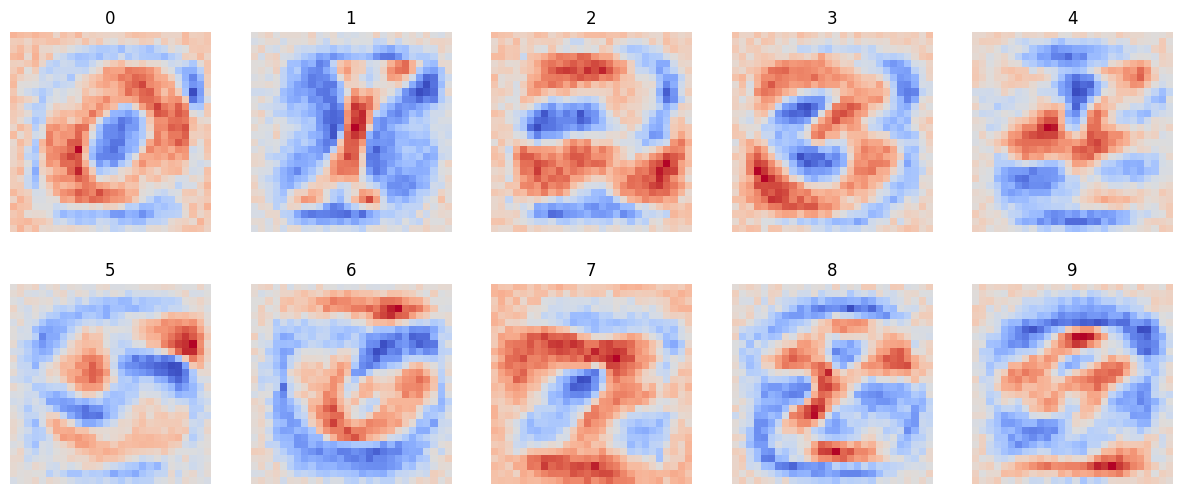

In [35]:
display_heatmaps(model)